
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/72_Mamba_State_Space_Models.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🐍 Mamba & SSM: Czy to koniec Transformera?

Transformer musi "patrzeć" na całą historię rozmowy naraz (macierz Attention). To kosztuje gigabajty pamięci.
Mamba używa **State Space Models (SSM)**.

Idea pochodzi z fizyki i sterowania (np. jak sterować termostatem):
$$ h'(t) = \mathbf{A}h(t) + \mathbf{B}x(t) $$
$$ y(t) = \mathbf{C}h(t) $$

*   **x(t):** Wejście (słowo).
*   **h(t):** Stan ukryty (pamięć/kontekst).
*   **y(t):** Wyjście (następne słowo).
*   **A, B, C:** Macierze, których się uczymy.

**Genialny trik:**
1.  Podczas **treningu** używamy splotów (Convolution), żeby liczyć wszystko naraz.
2.  Podczas **generowania** używamy rekurencji (Recurrence), żeby liczyć krok po kroku (bardzo szybko).

Zaimplementujemy prostą warstwę SSM od zera.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
D_MODEL = 8   # Wymiar wejścia
D_STATE = 16  # Wymiar stanu ukrytego (Latent State)

print(f"Symulacja SSM na: {DEVICE}")

Symulacja SSM na: cuda


## Krok 1: Dyskretyzacja (Świat ciągły vs Komputer)

Równania SSM są ciągłe (dla fizyki). Komputery są dyskretne (kroki czasowe).
Musimy zamienić macierze $\mathbf{A}$ i $\mathbf{B}$ na ich dyskretne odpowiedniki $\overline{\mathbf{A}}$ i $\overline{\mathbf{B}}$.

Używamy metody **Zero-Order Hold (ZOH)** i parametru $\Delta$ (Delta - krok czasu).
$$ \overline{\mathbf{A}} = \exp(\Delta \mathbf{A}) $$
$$ \overline{\mathbf{B}} = (\Delta \mathbf{A})^{-1} (\exp(\Delta \mathbf{A}) - I) \cdot \Delta \mathbf{B} $$

W uproszczeniu: $\overline{\mathbf{A}}$ mówi nam, jak bardzo pamięć "zanika" z kroku na krok.

In [2]:
def discretize(A, B, C, delta):
    # Uproszczona dyskretyzacja (przybliżenie Bilinearne dla szybkości)
    # W prawdziwej Mambie używa się dokładniejszych metod
    
    dt = delta.unsqueeze(-1) # [D_model, 1]
    
    # A_bar (Decay): Jak bardzo stan zanika?
    # exp(delta * A)
    dA = A * dt
    A_bar = torch.exp(dA)
    
    # B_bar (Input): Jak bardzo nowe wejście wpływa na stan?
    # (1/A * (exp(A*dt) - 1)) * B
    B_bar = (1/A * (torch.exp(A * dt) - 1)) * B
    
    return A_bar, B_bar, C

print("Funkcja dyskretyzacji gotowa.")

Funkcja dyskretyzacji gotowa.


## Krok 2: Widok Rekurencyjny (RNN Mode)

To tryb używany przez ChatGPT/Mambę podczas rozmowy z użytkownikiem (Inference).
Pamiętamy tylko **ostatni stan** ($h_{t-1}$).
Nowy stan to:
$$ h_t = \overline{\mathbf{A}} h_{t-1} + \overline{\mathbf{B}} x_t $$
$$ y_t = \mathbf{C} h_t $$

To jest super szybkie ($O(1)$) i zużywa mało pamięci.

In [3]:
class SSMLayer(nn.Module):
    def __init__(self, d_model, d_state):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        
        # Parametry (Trainable)
        # A musi być ujemne, żeby system był stabilny (pamięć nie wybuchała)
        self.A = nn.Parameter(torch.randn(d_model, d_state) * 0.5 - 1.0)
        self.B = nn.Parameter(torch.randn(d_model, d_state))
        self.C = nn.Parameter(torch.randn(d_model, d_state))
        
        # Krok czasu (Delta) - też się go uczymy!
        self.delta = nn.Parameter(torch.rand(d_model))

    def forward_rnn(self, x):
        # x: [Batch, Seq_Len, D_Model]
        batch_size, seq_len, _ = x.shape
        
        # 1. Dyskretyzacja parametrów
        A_bar, B_bar, C = discretize(self.A, self.B, self.C, F.softplus(self.delta))
        
        # 2. Pętla rekurencyjna (RNN)
        h = torch.zeros(batch_size, self.d_model, self.d_state).to(x.device) # Stan początkowy
        outputs = []
        
        for t in range(seq_len):
            x_t = x[:, t, :] # Obecny token
            
            # Wzór RNN: h_new = A_bar * h_old + B_bar * x
            # Używamy element-wise multiplication dla uproszczenia (Diagonal SSM)
            h = A_bar * h + B_bar * x_t.unsqueeze(-1)
            
            # Wyjście: y = C * h
            y_t = torch.sum(C * h, dim=-1) # Rzutujemy stan na wyjście
            outputs.append(y_t)
            
        return torch.stack(outputs, dim=1)

model = SSMLayer(D_MODEL, D_STATE).to(DEVICE)
print("Warstwa SSM stworzona.")

Warstwa SSM stworzona.


## Krok 3: Widok Splotowy (Convolutional Mode)

To tryb używany podczas **treningu**.
Zamiast pętli `for` (która jest wolna na GPU), możemy zauważyć, że wzór SSM można zapisać jako **długi splot (Convolution)**.

Jądro splotu (Kernel) $\mathbf{K}$ to po prostu "zasięg pamięci".
Możemy obliczyć całą sekwencję naraz (równolegle), używając FFT (Fast Fourier Transform). To dlatego Mamba trenuje się tak szybko jak Transformer.

Wejście: torch.Size([1, 20, 8])
Wyjście: torch.Size([1, 20, 8])


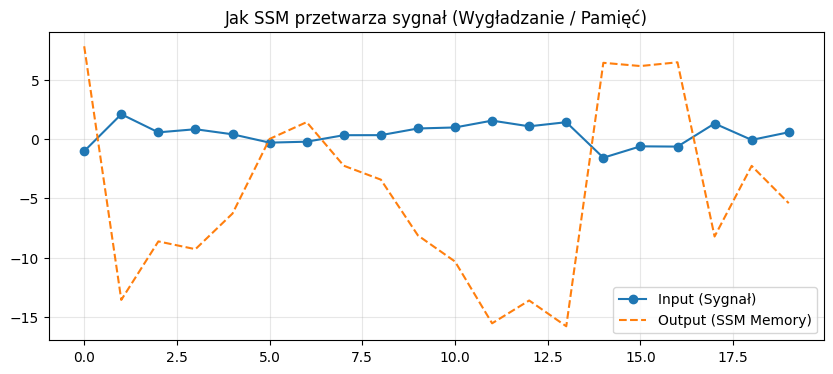

In [4]:
# Symulacja danych
x_input = torch.randn(1, 20, D_MODEL).to(DEVICE) # Sekwencja 20 kroków

# Uruchamiamy tryb RNN
output_rnn = model.forward_rnn(x_input)

print(f"Wejście: {x_input.shape}")
print(f"Wyjście: {output_rnn.shape}")

# Wizualizacja jednego kanału
plt.figure(figsize=(10, 4))
plt.plot(x_input[0, :, 0].cpu().detach().numpy(), label='Input (Sygnał)', marker='o')
plt.plot(output_rnn[0, :, 0].cpu().detach().numpy(), label='Output (SSM Memory)', linestyle='--')
plt.title("Jak SSM przetwarza sygnał (Wygładzanie / Pamięć)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 🧠 Podsumowanie: Selektywność (Selective Scan)

To, co zrobiliśmy powyżej, to klasyczne SSM (jak w modelu S4).
**Mamba** dodaje do tego **Selektywność**.

W zwykłym SSM macierze $\mathbf{A}, \mathbf{B}, \Delta$ są stałe dla całego tekstu.
W Mambie te macierze **zależą od wejścia $x(t)$**.
*   Model widzi słowo "Umbrella".
*   Zmienia swoje $\Delta$ i $\mathbf{A}$, żeby "otworzyć bramkę pamięci" i zapisać to słowo na długo.
*   Widzi słowo "the".
*   Zmienia parametry, żeby to zignorować.

Dzięki temu Mamba potrafi filtrować informacje (Selectivity), czego stare RNN nie potrafiły, a robi to szybciej niż Transformer.